<a href="https://colab.research.google.com/github/RUCUAL/Machine-Learning/blob/main/Unidad02/XGBoost%20(Extreme%20Gradient%20Boosting).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#5. XGBoost (Extreme Gradient Boosting)
Este es un modelo de boosting que a menudo ofrece el mejor rendimiento predictivo.
Parámetros Sugeridos para Exploración:
• n_estimators: Número de rondas de boosting (árboles).
• learning_rate: Tasa de aprendizaje (cuánto se ajusta el modelo en cada paso).
Ejecución y Análisis:
1. Ejecución 1 (Parámetros por defecto): Entrenar el modelo con los parámetros
estándar.
2. Ejecución 2 (Ajuste de Parámetros): Reducir el learning_rate (ej., de 0.1 a 0.01) y
aumentar el n_estimators (ej., a 500). Esto ilustra el trade-off entre velocidad y
precisión.
3. Reporte: Comparar el entre las dos ejecuciones e identificar la Importancia de
Características.

**CARGAR LIBRERIRAS Y DATOS**

**librerías necesarias**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración para mostrar todas las columnas
pd.set_option('display.max_columns', None)

**Cargar el dataset**

In [2]:
file_name = 'DATASET_Asesinatos.csv'
try:
    df = pd.read_csv(file_name, encoding='latin-1')
    print(f"Dataset '{file_name}' cargado exitosamente.")
except FileNotFoundError:
    print(f"ERROR: No se encontró el archivo '{file_name}'. Asegúrate de subirlo a Colab.")

Dataset 'DATASET_Asesinatos.csv' cargado exitosamente.


**Inspección Inicial**

In [3]:
print("\n--- Inspección de Datos ---")
print(f"Dimensiones del Dataset (filas, columnas): {df.shape}")
print("\nPrimeras 5 filas:")
print(df.head())
print("\nInformación de tipos de datos y valores nulos:")
df.info()


--- Inspección de Datos ---
Dimensiones del Dataset (filas, columnas): (3000, 16)

Primeras 5 filas:
                Estado  id_area  habitantes  area_km2  ingresos_medios  \
0               Puebla        1      207953     26.70            48018   
1              Durango        2       80226     17.39            50295   
2              Tabasco        3      260806     70.69            50795   
3  Baja California Sur        4      969508    830.49            68910   
4       Aguascalientes        5       69478     30.59            54248   

   edad_media_poblacion  densidad_poblacional  indice_gini  \
0                  40.8               7787.47        0.522   
1                  42.4               4612.66        0.346   
2                  39.5               3689.22        0.417   
3                  27.3               1167.39        0.399   
4                  36.2               2271.26        0.422   

   tasa_desempleo_juvenil  porcentaje_sin_diploma_secundaria  \
0               

**Verificación de Variables Clave**

In [4]:
target_variable = 'tasa_asesinatos_por_100mil'
initial_predictors = [
    'indice_gini',
    'tasa_desempleo_juvenil',
    'porcentaje_sin_diploma_secundaria',
    'ingresos_medios',
    'densidad_poblacional',
    'gasto_policial_per_capita',
    'inversion_programas_sociales_per_capita'
]

missing_cols = [col for col in [target_variable] + initial_predictors if col not in df.columns]

if missing_cols:
    print(f"\n ERROR: Faltan las siguientes columnas requeridas: {missing_cols}")
else:
    print("\n Todas las variables objetivo y predictoras iniciales están presentes.")


 Todas las variables objetivo y predictoras iniciales están presentes.


**Preparación para el modelado: Manejo de Nulos (si los hay)**

In [5]:
rows_before = df.shape[0]
df.dropna(subset=[target_variable] + initial_predictors, inplace=True)
rows_after = df.shape[0]

if rows_before > rows_after:
    print(f"\nSe eliminaron {rows_before - rows_after} filas con valores nulos para las variables clave.")
else:
    print("\nNo se encontraron valores nulos en las variables clave.")


No se encontraron valores nulos en las variables clave.


**Calcular la correlación de Pearson con la variable objetivo**

In [6]:
target_variable = 'tasa_asesinatos_por_100mil'
initial_predictors = [
    'indice_gini',
    'tasa_desempleo_juvenil',
    'porcentaje_sin_diploma_secundaria',
    'ingresos_medios',
    'densidad_poblacional',
    'gasto_policial_per_capita',
    'inversion_programas_sociales_per_capita'
]

correlation_matrix = df[[target_variable] + initial_predictors].corr()
target_correlations = correlation_matrix[target_variable].drop(target_variable).sort_values(ascending=False)

print("\n--- Correlación de Pearson con 'tasa_asesinatos_por_100mil' ---")
print(target_correlations)


--- Correlación de Pearson con 'tasa_asesinatos_por_100mil' ---
indice_gini                                0.550872
porcentaje_sin_diploma_secundaria          0.346234
tasa_desempleo_juvenil                     0.261754
densidad_poblacional                       0.164929
gasto_policial_per_capita                 -0.011940
inversion_programas_sociales_per_capita   -0.050768
ingresos_medios                           -0.284239
Name: tasa_asesinatos_por_100mil, dtype: float64


**Visualización de las correlaciones**

/tmp/ipython-input-908738934.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_correlations.values, y=target_correlations.index, palette="viridis")


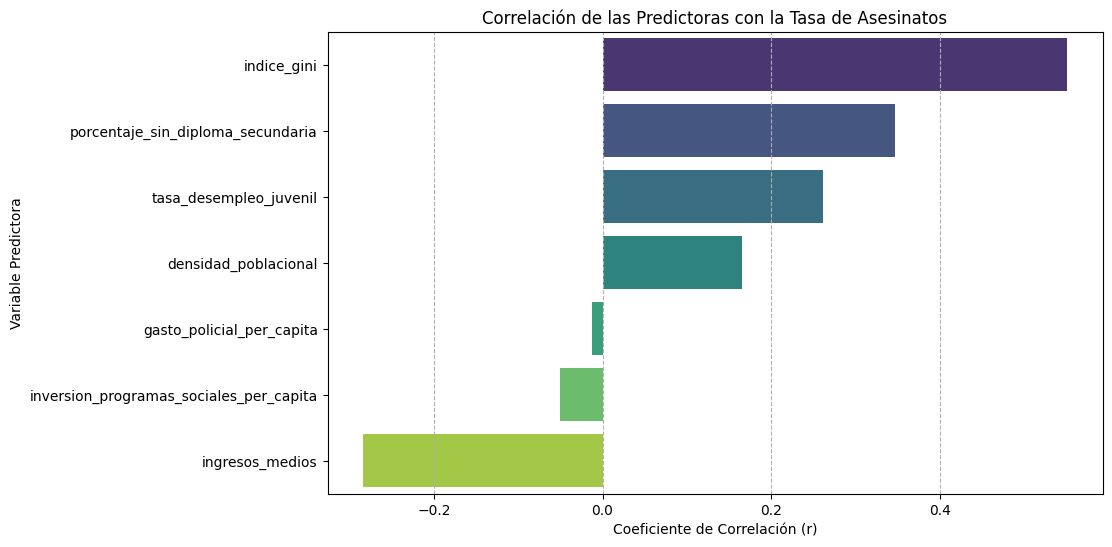

In [7]:
plt.figure(figsize=(10, 6))
sns.barplot(x=target_correlations.values, y=target_correlations.index, palette="viridis")
plt.title('Correlación de las Predictoras con la Tasa de Asesinatos')
plt.xlabel('Coeficiente de Correlación (r)')
plt.ylabel('Variable Predictora')
plt.grid(axis='x', linestyle='--')
plt.show()

#**Ejecución 1: Parámetros por Defecto**

**Instalar la librería xgboost: !pip install xgboost**

In [63]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
import pandas as pd
import matplotlib.pyplot as plt

**Inicializar y entrenar el modelo con parámetros por defecto**

In [64]:
try:
    xgb_regressor_default = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
    xgb_regressor_default.fit(X_train_scaled, Y_train)
    X_test_data = X_test_scaled
except NameError:

    xgb_regressor_default = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
    xgb_regressor_default.fit(X_train, Y_train)
    X_test_data = X_test

**Evaluar R2 en conjunto de prueba**

In [65]:
Y_test_pred_xgb_default = xgb_regressor_default.predict(X_test_data)
r2_test_xgb_default = r2_score(Y_test, Y_test_pred_xgb_default)

print("--- Resultados XGBoost (Parámetros por Defecto) ---")
print(f"R2 de Prueba: {r2_test_xgb_default:.4f}")

--- Resultados XGBoost (Parámetros por Defecto) ---
R2 de Prueba: 0.4814


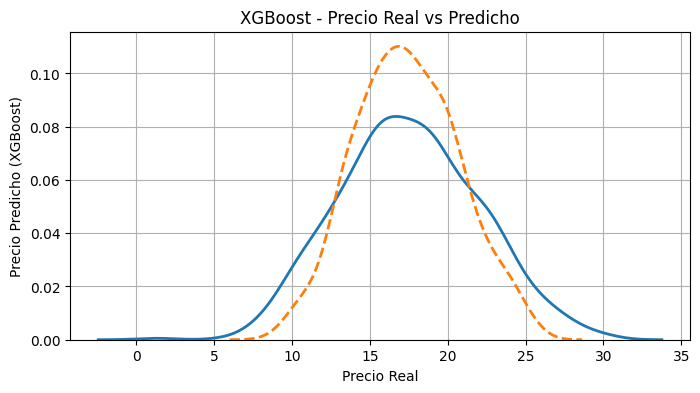

In [66]:
plt.figure(figsize=(8, 4))
sns.kdeplot(Y_test, label='Precio Real', linewidth=2)
sns.kdeplot(Y_test_pred_xgb_default, label='Precio Predicho', linewidth=2, linestyle='--')
plt.xlabel("Precio Real")
plt.ylabel("Precio Predicho (XGBoost)")
plt.title("XGBoost - Precio Real vs Predicho")
plt.grid(True)
plt.show()

#**Ejecución 2: Ajuste de Parámetros**

**Entrenar el modelo con ajuste fino (slow learning rate)**

In [67]:
xgb_regressor_tuned = XGBRegressor(
    random_state=42,
    n_estimators=500,        # Más árboles
    learning_rate=0.01,      # Tasa de aprendizaje más baja
    n_jobs=-1,               # Usar todos los núcleos disponibles
    early_stopping_rounds=10 # Detener si no mejora en 10 rondas (opcional)
)

try:
    xgb_regressor_tuned.fit(
        X_train_scaled, Y_train,
        eval_set=[(X_test_scaled, Y_test)],
        verbose=False
    )
    X_test_data = X_test_scaled
except NameError:
    xgb_regressor_tuned.fit(
        X_train, Y_train,
        eval_set=[(X_test, Y_test)],
        verbose=False
    )
    X_test_data = X_test

**Evaluar R2 en conjunto de prueba**

In [68]:
Y_test_pred_xgb_tuned = xgb_regressor_tuned.predict(X_test_data)
r2_test_xgb_tuned = r2_score(Y_test, Y_test_pred_xgb_tuned)

print("--- Resultados XGBoost (Ajustado) ---")
print(f"R2 de Prueba: {r2_test_xgb_tuned:.4f}")

--- Resultados XGBoost (Ajustado) ---
R2 de Prueba: 0.5051


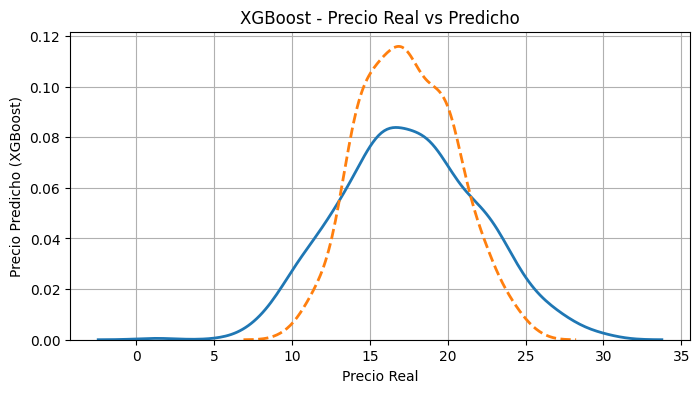

In [69]:
plt.figure(figsize=(8, 4))
sns.kdeplot(Y_test, label='Precio Real', linewidth=2)
sns.kdeplot(Y_test_pred_xgb_tuned, label='Precio Predicho', linewidth=2, linestyle='--')
plt.xlabel("Precio Real")
plt.ylabel("Precio Predicho (XGBoost)")
plt.title("XGBoost - Precio Real vs Predicho")
plt.grid(True)
plt.show()

#**Reporte y Análisis de Importancia de Características**

In [70]:
print("\n--- Comparación de R2 de Prueba (XGBoost) ---")
print("{:<25} | {:<15}".format("Ejecución", "R2 de Prueba"))
print("-" * 40)
print("{:<25} | {:<15.4f}".format("1. Por Defecto (0.1/100)", r2_test_xgb_default))
print("{:<25} | {:<15.4f}".format("2. Ajustado (0.01/500)", r2_test_xgb_tuned))


--- Comparación de R2 de Prueba (XGBoost) ---
Ejecución                 | R2 de Prueba   
----------------------------------------
1. Por Defecto (0.1/100)  | 0.4814         
2. Ajustado (0.01/500)    | 0.5051         


**Obtener las importancias del modelo ajustado**

In [71]:
final_xgb_model = xgb_regressor_tuned
feature_importances_xgb = pd.Series(
    final_xgb_model.feature_importances_,
    index=X.columns
)

**Graficar la importancia**

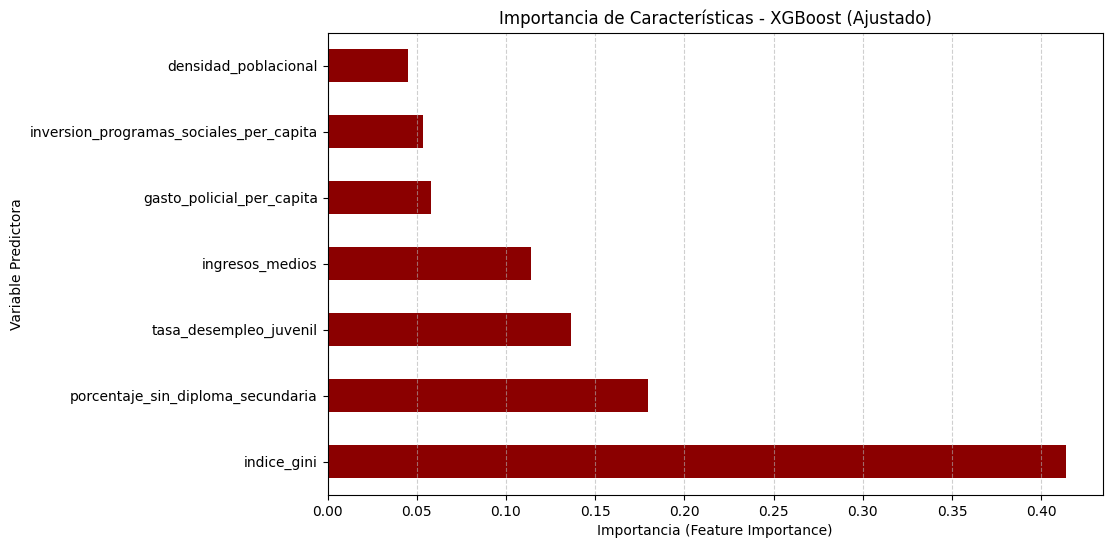


--- Top 3 Variables más Importantes (XGBoost) ---
indice_gini                          0.413618
porcentaje_sin_diploma_secundaria    0.179339
tasa_desempleo_juvenil               0.136492


In [72]:
plt.figure(figsize=(10, 6))
feature_importances_xgb.sort_values(ascending=False).plot(kind='barh', color='darkred')
plt.title('Importancia de Características - XGBoost (Ajustado)')
plt.xlabel('Importancia (Feature Importance)')
plt.ylabel('Variable Predictora')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.savefig('feature_importance_xgb.png')
plt.show()

print("\n--- Top 3 Variables más Importantes (XGBoost) ---")
print(feature_importances_xgb.sort_values(ascending=False).head(3).to_string())